# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импорт нужных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 12345

Загрузим и изучим данные

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Выделим информативные для модели признаки:
- VehicleType
- RegistrationYear
- Gearbox
- Power
- Model
- Kilometer
- FuelType
- Brand
- NotRepaired

Целевой признак:
- Price

Остальные столбцы можно удалить из датасета, так как они не информативны:
- дата скачивания анкеты из базы
- дата создания анкеты
- количество фотогорафий
- почтовый индекс
- дата последней активности пользователя

Ничего из этого не влияет на стоимость автомобиля

In [6]:
data = data.drop(['DateCrawled', 'RegistrationMonth','DateCreated','NumberOfPictures','PostalCode', 'LastSeen'], axis =1)

In [7]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Удалим явные дубликаты

In [8]:
display(data.duplicated().sum())
data = data.drop_duplicates()

45040

Проверим пропуски

In [9]:
data.isna().sum()

Price                   0
VehicleType         34559
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
NotRepaired         64558
dtype: int64

В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired присутствуют пропуски. Нужно их обработать.

Пропуски в VehicleType, Gearbox и FuelType можно заполнить наиболее частыми значениями при помощи .mode()

In [10]:
data['VehicleType'] = data['VehicleType'].fillna(data['VehicleType'].mode().values[0])
data['Gearbox'] = data['Gearbox'].fillna(data['Gearbox'].mode().values[0])
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].mode().values[0])

Пропуски в Model и NotRepaired заменим на 'unknown'

In [11]:
data['Model'] = data['Model'].fillna('unknown')
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

In [12]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

Проверка значений

In [13]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [14]:
def show(data):
    for column in data.columns:
        print('Значения столбца', column)
        print()
        print(data[column].value_counts(sort = True))
        print()

In [15]:
show(data)

Значения столбца Price

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: Price, Length: 3731, dtype: int64

Значения столбца VehicleType

sedan          112765
small           67548
wagon           56367
bus             25830
convertible     18195
coupe           14690
suv             10776
other            3158
Name: VehicleType, dtype: int64

Значения столбца RegistrationYear

2000    20840
2005    19350
1999    18876
2001    17234
2006    17201
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

Значения столбца Gearbox

manual    249981
auto       59348
Name: Gearbox, dtype: int64

Значения столбца Power

0       35978
75      19530
60      12880
150     12650
90      11320
        ...  
525         1
6018        1
1920        1
640         1
902         1
Name: Power, Length: 712, dtype: in

1. Price - нулевые значения
2. RegistrationYear - неадекватные значения
3. Power - неадекватные значения

Изучим гистограмму по столбцу Price, чтоб визуально оценить значения

<AxesSubplot:>

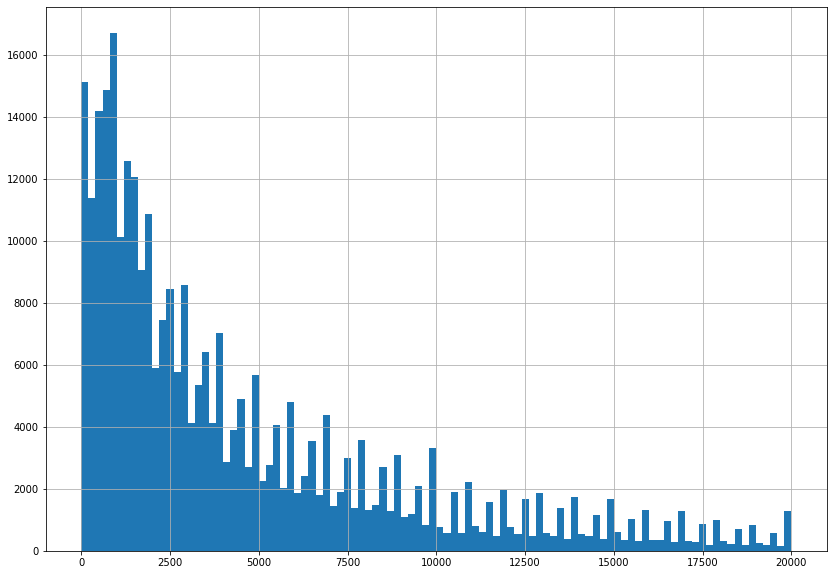

In [16]:
data['Price'].hist(bins=100, figsize=(14,10))

Судя по гистограамме в столбце присуствует много нулевых и околонулевых значений, так же присутствуют выбросы после 10000.

Нужно обработать столбец, чтоб убрать вредные данные. Автомобиль может стоит 20000 евро, но близких к нулю цен на рынке нет.

Можно убрать все данные до 5% квантиля, таким образом избавившись от очень маленьких значений

In [17]:
display(data['Price'].quantile([.05]))

0.05    200.0
Name: Price, dtype: float64

200 вполне нормальная цена за старый и битый автомобиль LADA

In [18]:
data = data.query('Price >= 200')

В столбце RegistrationYear есть нереальные для года регистрации авто значения, такие как 1200 или 8888.

Исправить это можно обратившьись к окружающему миру. Сейчас 2022 год, серийный выпуск автомобилей начал зарождаться с начала 20 века.

Соответственно все данные не входящие в отрезок с 1900 по 2022 нужно убрать

In [19]:
data = data.query('1900 <= RegistrationYear <= 2022')

In [20]:
data['RegistrationYear'].describe()

count    294103.000000
mean       2003.327045
std           7.476435
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

Теперь изучим столбец Power

Построим гистограмму, сразу уберём значения свыше 1200 л.с.

<AxesSubplot:>

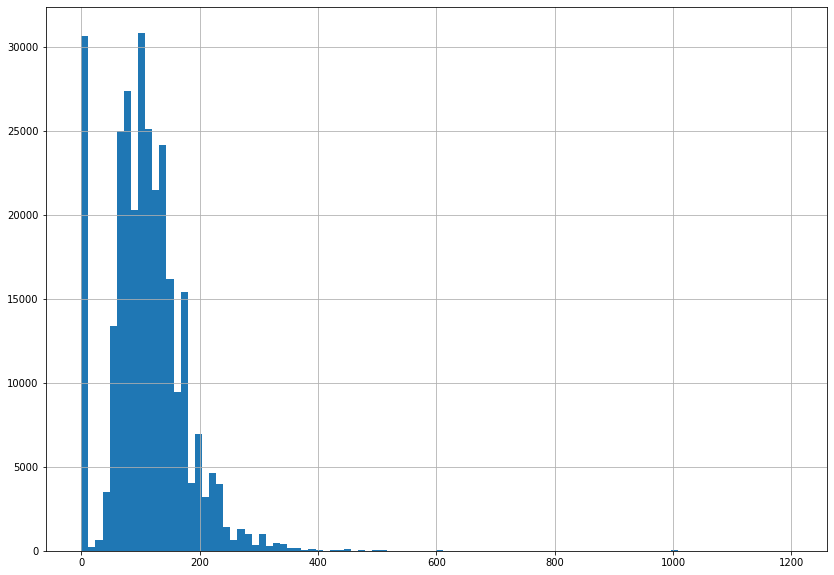

In [21]:
data = data.query('Power <= 1200')
data['Power'].hist(bins=100, figsize=(14,10))

Много нулевых и немного околонулевых значений

Можно убрать значения меньше 10 л.с.(маленькие электрокары могут быть такой мощности)

In [22]:
data = data.query('Power >= 10')

Посмотрим на корреляцию признаков

In [23]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.402263,0.470558,-0.379256
RegistrationYear,0.402263,1.000000,0.083662,-0.239033
Power,0.470558,0.083662,1.000000,0.117719
Kilometer,-0.379256,-0.239033,0.117719,1.000000


Всё в порядке. Сильне всех коррелирует с целевым признаком признак Power

### Вывод

- Загружены и изучены данные
- Из данных удалены ненужные для модели признаки
- Обработаны пропуски
- Удалены выбросы и нулевые значения
- Изучена корреляция

**Данные готовы**

## Обучение моделей

**Будем обучать следующие модели:**

**1. Линейная регрессия**

**2. Случайный лес**

**3. LightGBM**

### Кодировка и выборки

In [24]:
data = data.astype({'VehicleType':'category',
                                  'Gearbox':'category',
                                  'Model':'category',
                                  'FuelType':'category',
                                  'Brand':'category',
                                  'NotRepaired':'category'})
features = data.drop('Price', axis=1)
target = data['Price']

ohe_features = pd.get_dummies(features, drop_first=True)

encoder = OrdinalEncoder()
cat_columns = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
cat_features = features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
oe_features = features.copy()
for column in cat_columns:
    oe_features[column] = cat_features[column]

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

ohe_features_train = ohe_features.loc[features_train.index, :]
ohe_features_test = ohe_features.loc[features_test.index, :]
oe_features_train = oe_features.loc[features_train.index, :]
oe_features_test = oe_features.loc[features_test.index, :]

### Линейная регрессия

In [25]:
%%time
lr_model = LinearRegression(n_jobs=-1)
lr_rmse = (cross_val_score(lr_model, ohe_features_train, target_train, 
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('LinearRegression RMSE =', lr_rmse)

LinearRegression RMSE = 2753.4161043180497
CPU times: user 45.4 s, sys: 21.2 s, total: 1min 6s
Wall time: 1min 6s


### Случайный лес

In [26]:
%%time
rf_model = RandomForestRegressor(criterion = "mse", random_state=RANDOM_STATE, n_estimators = 100)
rf_rmse = (cross_val_score(rf_model, oe_features_train, target_train, 
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RandomForestRegressorRMSE =', rf_rmse)

RandomForestRegressorRMSE = 1712.9209878939523
CPU times: user 3min 10s, sys: 3.85 s, total: 3min 14s
Wall time: 3min 15s


### LightGBM

In [27]:
lgbm_model = LGBMRegressor() 
parameters = [{'num_leaves':[31, 50, 100], 
                'learning_rate':[0.1, 0.3, 0.5],
                'max_depth':[5,10,15],
                'random_state':[RANDOM_STATE]}]
grid = GridSearchCV(lgbm_model, parameters, scoring='neg_mean_squared_error')
grid.fit(oe_features_train, target_train)
print(grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 15, 'num_leaves': 100, 'random_state': 12345}


In [28]:
lgbm_model = LGBMRegressor(max_depth = 15, num_leaves = 100, learning_rate=0.3, random_state=RANDOM_STATE)
lgbm_rmse = (cross_val_score(lgbm_model, oe_features_train, target_train, 
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('LinearRegression RMSE =', lgbm_rmse)

LinearRegression RMSE = 1641.2437174863392


## Анализ моделей

Перед началом работы были определены китерии, которые важны заказчику:
- качество предсказания
- время обучения модели
- время предсказания модели

**Разберем каждый критерий по отдельности**

### Качество предсказания

RMSE у каждой модели:
- Линейная регрессия - 2753.416
- Случайный лес - 1712.920
- LightGBM - 1641.243

Значение метрики RMSE должно быть меньше 2500, соответственно линейная регрессия нам уже не подходит

### Время обучения модели

In [29]:
%%time
rf_model.fit(oe_features_train, target_train)

CPU times: user 46.1 s, sys: 795 ms, total: 46.9 s
Wall time: 47 s


RandomForestRegressor(random_state=12345)

In [30]:
%%time
lgbm_model.fit(oe_features_train, target_train)

CPU times: user 14.2 s, sys: 93.6 ms, total: 14.3 s
Wall time: 14.6 s


LGBMRegressor(learning_rate=0.3, max_depth=15, num_leaves=100,
              random_state=12345)

Время обучения:
- Случайный лес - 47 секунд
- LightGBM - 14.6 секунд

Модель LightGBM обучается гораздо быстрее

### Время предсказания модели

In [31]:
%%time
rf_model.predict(oe_features_test)

CPU times: user 2.89 s, sys: 12.1 ms, total: 2.9 s
Wall time: 2.97 s


array([  921.73277259,  1162.89833333,  3143.53213734, ...,
       13681.17083333,  9934.08333333, 11031.05316667])

In [32]:
%%time
lgbm_model.predict(oe_features_test)

CPU times: user 518 ms, sys: 0 ns, total: 518 ms
Wall time: 512 ms


array([  891.15621185,  1445.24114567,  3230.80198942, ...,
       13755.34407857, 10284.2986796 , 12601.90523835])

Время предсказания:
- Случайный лес - 2.97 секунд
- LightGBM - 0.512 секунд

Модель LightGBM быстрее обучается, быстрее предсказывает и по RMSE выглядит лучше

## Вывод

В ходе работы было выполнено:

- Загружены данные и проведена предобработка
- Обучены модели
- Выбрана лучшая модель в соответствии с критериями заказчика. Этой моделью стала LightGBM